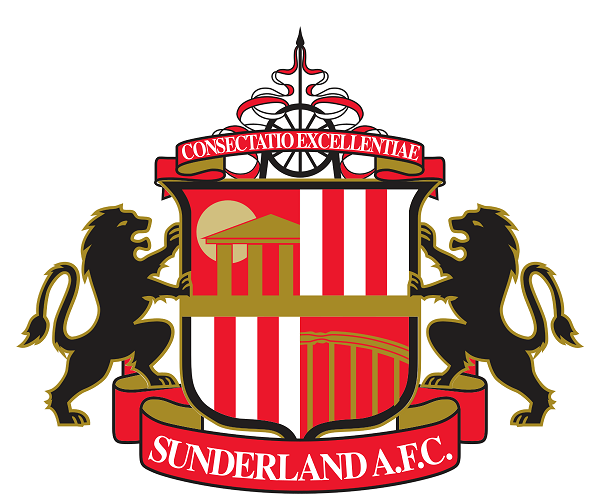

This project scrapes the scores for Sunderland Athletic Football Club (Sunderland, England) and aggregates the for/against breakdowns for visualization. BeautifulSoup was used extensively for the web scraping.

Concepts Shown: Web Scraping, File I/O, Visualizations

In [150]:
#pip install beautifulsoup4

from bs4 import BeautifulSoup
import requests
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

Read the list of valid season IDs using BeautifulSoup. This is necessary because some SeasonIDs have been skipped.

In [48]:
list_of_seasons_url = 'http://www.thestatcat.co.uk/seasonlist.aspx'
url_get = requests.get(list_of_seasons_url)
soup = BeautifulSoup(url_get.content, 'lxml')

season_urls = soup.findAll('a', {'class': 'menuitem'})

season_ids = []

for url in season_urls:
    seasonID = url['href'].split('=')
    season_ids.append(seasonID[1])

For each season, we will do the following:
    * Load the season's individual match scores
    * Read the results match by match, saving goals for and goals against
    * Aggregate our results based on goals for AND goals against
    * Save the results to a text file for future use (avoid repeated querying)

In [51]:
for sid in season_ids:
    year = ''
    year_url = 'http://www.thestatcat.co.uk/Season.aspx?SeasonID=' + str(sid)
    matches_url = "http://www.thestatcat.co.uk/SeasonGames.aspx?SeasonID=" + str(sid)

    print('Reading: ' + year_url)
    
    #get the year from the year_url - we will use this to save the data locally
    url_get = requests.get(year_url)
    soup = BeautifulSoup(url_get.content, 'lxml')
    
    #This data has a header row. We can check for a value that only exists on the data rows to make sure we're on a data row.
    if soup.find(attrs={'class': 'h1globspan'}):
        year = soup.find(attrs={'class': 'h1globspan'}).text
        year = year.split(':')
        year = str(year[0]).strip()
        year = year + '.csv'

        #get the data for the individual matches - we will aggregate this at the end    
        url_get = requests.get(matches_url)
        soup = BeautifulSoup(url_get.content, 'lxml')

        scores = []

        matches = soup.findAll('div', {'class': 'seasonpageline'})

        for match in matches:
            indiv_match_tag = match.find(attrs={'class': 'gameslineforgoals'})      

            if indiv_match_tag:
                if match.find(class_='gameslinecomp').text == 'Lge':
                    goals_for  = match.find(class_='gameslineforgoals').text
                    goals_agst = match.find(class_='gameslineagstgoals').text        

                    scores.append([goals_for, goals_agst])

            scores_df = pd.DataFrame(scores, columns=['for', 'against'])
            scores_df = scores_df.groupby(['for','against']).size().reset_index().rename(columns={0:'count'})

        if len(scores_df.index) > 0:
            scores_df.to_csv(year, index=False)


http://www.thestatcat.co.uk/Season.aspx?SeasonID=2
http://www.thestatcat.co.uk/Season.aspx?SeasonID=3
http://www.thestatcat.co.uk/Season.aspx?SeasonID=4
http://www.thestatcat.co.uk/Season.aspx?SeasonID=5
http://www.thestatcat.co.uk/Season.aspx?SeasonID=6
http://www.thestatcat.co.uk/Season.aspx?SeasonID=7
http://www.thestatcat.co.uk/Season.aspx?SeasonID=8
http://www.thestatcat.co.uk/Season.aspx?SeasonID=9
http://www.thestatcat.co.uk/Season.aspx?SeasonID=11
http://www.thestatcat.co.uk/Season.aspx?SeasonID=10
http://www.thestatcat.co.uk/Season.aspx?SeasonID=12
http://www.thestatcat.co.uk/Season.aspx?SeasonID=13
http://www.thestatcat.co.uk/Season.aspx?SeasonID=14
http://www.thestatcat.co.uk/Season.aspx?SeasonID=15
http://www.thestatcat.co.uk/Season.aspx?SeasonID=16


KeyboardInterrupt: 

We could have changed the code above to compile all of the data but instead we've saved it locally so we don't have to repeatedly download it. We will read all of the CSV files back into a dataframe and aggregate them.

In [170]:
#load the data in from text files
path = r'./' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

scores_df = pd.concat(li, axis=0, ignore_index=True)

scores_df = scores_df.groupby(['for','against']).size().reset_index().rename(columns={0:'count'})


We will use seaborn's heatmap with some custom colors for our gradient (okay, they're just red and white).

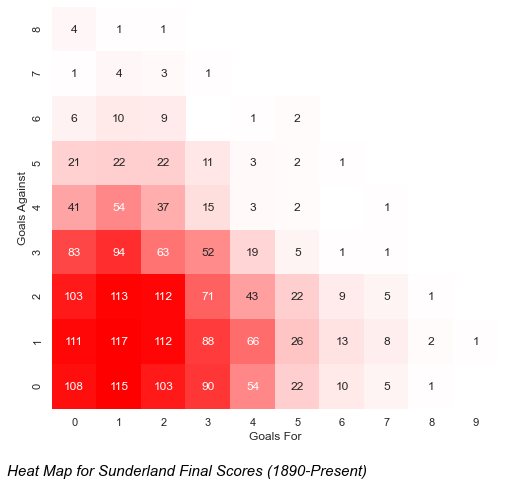

In [179]:
#build out the graph
#first we have to pivot the values since we've already aggregated them.
values = pd.pivot_table(scores_df, values='count', index=['against'], columns = ['for'], aggfunc=np.sum)
values.sort_index(level=0, ascending=False, inplace=True)

#custom color map. just white to red
cmap = mcolors.LinearSegmentedColormap.from_list("n",['#ffffff','#ff0000'])

ax = plt.figure(figsize=(8, 8))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
ax = sns.heatmap(values,
                 vmin=0,
                 cmap=cmap,#"Reds",  #BrBG is also good
                 robust = True, 
                 alpha = 1,
                 square = True,
                 annot = True,
                 cbar = False,
                fmt='g')
plt.xlabel('Goals For')
plt.ylabel('Goals Against')
plt.text(-1,10.5, "Heat Map for Sunderland Final Scores (1890-Present)", fontsize = 15, color='Black', fontstyle='italic')
plt.show()